# CNN for Classification: Cats vs. Dogs

![catvsdog](https://miro.medium.com/v2/resize:fit:1400/format:webp/0*qejv1I-FYujIjqev.jpg)

dataset source: https://www.microsoft.com/en-us/download/details.aspx?id=54765


In [ ]:
path = "../../data/kagglecatsanddogs_5340/PetImages"

In [ ]:
import os, sys, shutil

# Move and organise data
def create_dataset_directories(base_dir: str) -> None:
    print("Start creation of dataset directories...")

    if not os.path.exists(base_dir):
        os.mkdir(base_dir)

    directories = ["train", "validation", "test"]
    for directory in directories:
        sub_dir = os.path.join(base_dir, directory)
        os.mkdir(sub_dir)
        os.mkdir(os.path.join(sub_dir, "cats"))
        os.mkdir(os.path.join(sub_dir, "dogs"))

    print("Done")


def copy_data(
    src: str, dst: str, example_name: str, fnames: list[str]
) -> None:
    print("Copying...")
    for fname in fnames:
        print(f"Copying {fname} to {dst}")
        shutil.copyfile(
            os.path.join(src, fname),
            os.path.join(dst, example_name + "." + fname)
        )


In [ ]:
import re
fnames_cats = [f for f in os.listdir(path + "/Cat") if re.match(r'[0-9]+.*\.jpg', f)]
fnames_dogs = [f for f in os.listdir(path + "/Dog") if re.match(r'[0-9]+.*\.jpg', f)]

In [ ]:
len(fnames_dogs)

In [ ]:
12500*0.8

In [ ]:
train_fnames_cats = fnames_cats[:8000]
val_fnames_cats = fnames_cats[8000:10000]
test_fnames_cats = fnames_cats[10000:]

train_fnames_dogs = fnames_dogs[:8000]
val_fnames_dogs = fnames_dogs[8000:10000]
test_fnames_dogs = fnames_dogs[10000:]

In [1]:
destination = "../../data/cats_vs_dogs"

In [ ]:
create_dataset_directories(destination)

copy_data(path + "/Cat", f"{destination}/train/cats/", "cat", train_fnames_cats)
copy_data(path + "/Dog", f"{destination}/train/dogs/", "dog", train_fnames_dogs)

copy_data(path + "/Cat", f"{destination}/validation/cats/", "cat", val_fnames_cats)
copy_data(path + "/Dog", f"{destination}/validation/dogs/", "dog", val_fnames_dogs)

copy_data(path + "/Cat", f"{destination}/test/cats/", "cat", test_fnames_cats)
copy_data(path + "/Dog", f"{destination}/test/dogs/", "dog", test_fnames_dogs)


## Remove corrupted images

In [ ]:
import shutil
import os
import time
from PIL import Image

# Method 1
def extract_corrupt_img_files(dir_path):
  """
  Gets corrupted image files within a directory
  
    Arguments:
        dir_path: a string representing the path for the target directory

    Returns:
        a list of the paths for the corrupted image files

  """ 
  i = 0
  beg = time.time()
  corrupted = []
  for filename in os.listdir(dir_path):
    i +=1
    if (i % 50 == 0):
      print(i, end =" ")
    if (i % 1000 == 0):
      print()
    try:
      img = Image.open(dir_path + '/' + filename)
    except:
      corrupted.append(filename)
      os.remove(dir_path + '/' + filename)
      continue

  end = time.time()
  print()
  print('*' * 50) 
  print("\nTASK FINISHED IN " + str(end - beg) + " seconds ")
  print("{} corrupted files found and removed in {}".format(len(corrupted), dir_path))
  print('*' * 50) 
  return corrupted

extract_corrupt_img_files(f"{destination}/test/cats/")

In [ ]:
from pathlib import Path
import imghdr

# Method 2

data_dir = f"{destination}/test/dogs/"
image_extensions = [".png", ".jpg"]  # add there all your images file extensions

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image and will be removed")
            os.remove(filepath)
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow and will be removed")
            os.remove(filepath)


In [ ]:
from pathlib import Path
import imghdr
test_dir = f"{destination}/test/"

# Method 3

img_link=list(Path(validation_dir).glob(r'**/*.jpg'))

count_num=0
for lnk in img_link:
    binary_img=open(lnk,'rb')
    find_img=tf.compat.as_bytes('JFIF') in binary_img.peek(10)#The JFIF is a JPEG File Interchange Format (JFIF). It is a standard which we gauge if an image is corrupt or substandard
    if not find_img:
        count_num+=1
        os.remove(str(lnk))
print('Total %d pcs image delete from Dataset' % count_num)

In [ ]:
import glob
# Method 4

img_paths = glob.glob(os.path.join(f"{destination}/train/",'*/*.*')) # assuming you point to the directory containing the label folders.

bad_paths = []

for image_path in img_paths:
    try:
      img_bytes = tf.io.read_file(image_path)
      decoded_img = tf.io.decode_image(img_bytes)
    except tf.errors.InvalidArgumentError as e:
      print(f"Found bad path {image_path}...{e}")
      bad_paths.append(image_path)
      os.remove(image_path)
    
    #print(f"{image_path}: OK")

print("BAD PATHS (removed):")
for bad_path in bad_paths:
    print(f"{bad_path}")

### Build your model

In [2]:
from keras import layers
from keras import models


model = models.Sequential([
    layers.Conv2D(
        32, (3, 3), activation="relu",
        input_shape=(150, 150, 3)
    ),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(512, activation="relu"),

    layers.Dense(1, activation="sigmoid")
])

model.compile(
    loss="binary_crossentropy",
    optimizer="rmsprop",
    metrics=["accuracy"]
)

In [3]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)       0

In [4]:
from keras.preprocessing.image import ImageDataGenerator
# process the data

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_dir = f"{destination}/train/"
validation_dir = f"{destination}/validation/"

batch_size=32

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode="binary"
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode="binary"
)

Found 14997 images belonging to 2 classes.
Found 3706 images belonging to 2 classes.


In [8]:
14997 / batch_size

468.65625

In [11]:
epochs = 15
len(train_generator) // epochs

31

In [12]:
# model sees each data point once
epochs = 15
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator) // epochs,  # len(train_generator)//epochs
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=len(validation_generator) // epochs
)

Epoch 1/15
31/31 [==============================] - 10s 291ms/step - loss: 0.8298 - accuracy: 0.5030 - val_loss: 0.6886 - val_accuracy: 0.5312
Epoch 2/15
31/31 [==============================] - 9s 281ms/step - loss: 0.6939 - accuracy: 0.5312 - val_loss: 0.6944 - val_accuracy: 0.4777
Epoch 3/15
31/31 [==============================] - 9s 276ms/step - loss: 0.6957 - accuracy: 0.5383 - val_loss: 0.6856 - val_accuracy: 0.5625
Epoch 4/15
31/31 [==============================] - 9s 276ms/step - loss: 0.6974 - accuracy: 0.5706 - val_loss: 0.7513 - val_accuracy: 0.5268
Epoch 5/15
31/31 [==============================] - 9s 276ms/step - loss: 0.6795 - accuracy: 0.5615 - val_loss: 0.6500 - val_accuracy: 0.6473
Epoch 6/15
31/31 [==============================] - 9s 281ms/step - loss: 0.6681 - accuracy: 0.6179 - val_loss: 0.6595 - val_accuracy: 0.6295
Epoch 7/15
31/31 [==============================] - 9s 275ms/step - loss: 0.6504 - accuracy: 0.6058 - val_loss: 0.5994 - val_accuracy: 0.7232
Epoch

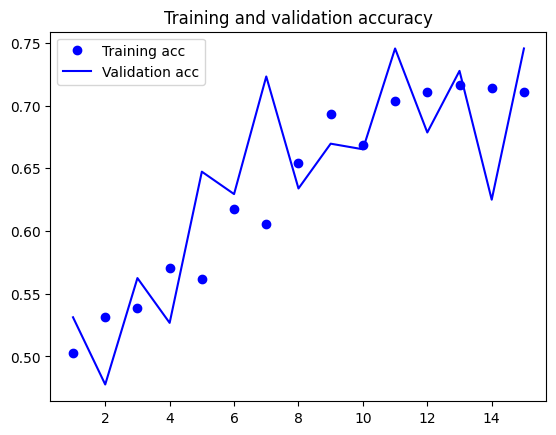

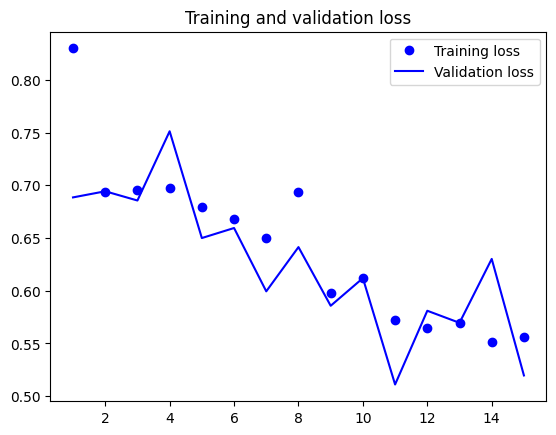

In [13]:
import matplotlib.pyplot as plt


acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")

plt.title("Training and validation accuracy")
plt.legend()

plt.figure()

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")

plt.legend()
plt.show()

## Data Augmentation

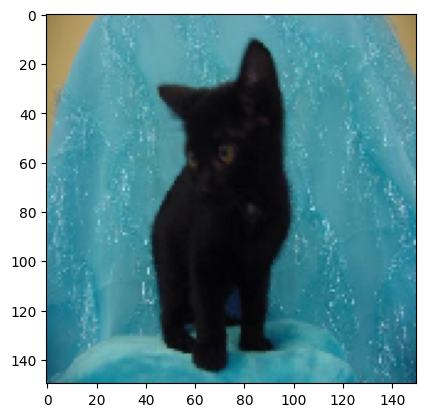

In [14]:
# deprecated
import os

import matplotlib.pyplot as plt

from more_itertools import take
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator


datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.5,
    horizontal_flip=True,
    fill_mode="nearest"
)

train_cats_dir = f"{destination}/train/cats/"

fnames = [
    os.path.join(train_cats_dir, fname)
    for fname in os.listdir(train_cats_dir)
]

img_path = fnames[92]
img = image.load_img(img_path, target_size=(150, 150))

x = image.img_to_array(img)
x = x.reshape((1,) + x.shape)
plt.imshow(image.array_to_img(x[0]))

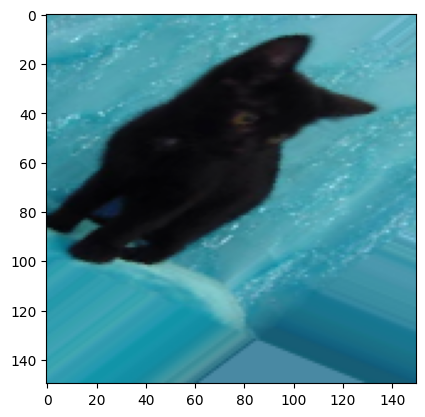

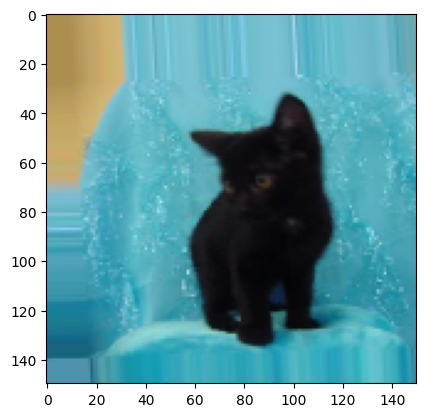

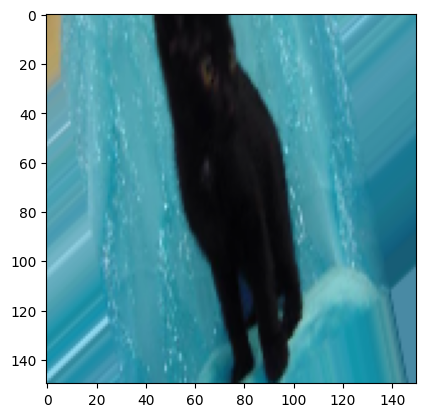

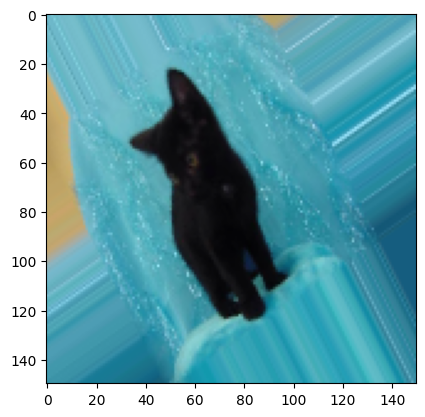

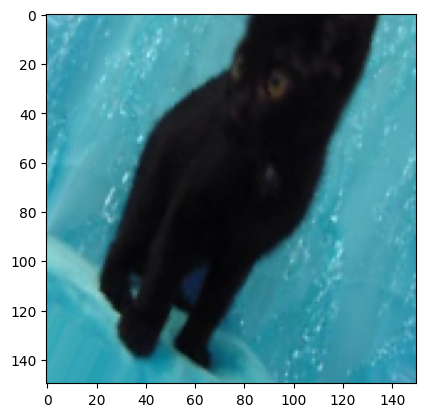

In [15]:
for batch in take(5, datagen.flow(x, batch_size=1)):
    plt.figure()
    imgplot = plt.imshow(image.array_to_img(batch[0]))

plt.show()

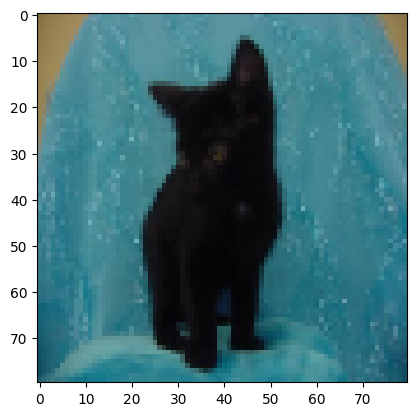

In [16]:
# keras preprocessing layers
import tensorflow as tf

IMG_SIZE = 80

# You can use the Keras preprocessing layers to resize your images to a consistent shape 
# (with tf.keras.layers.Resizing), and to rescale pixel values (with tf.keras.layers.Rescaling)

resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255)
])

result = resize_and_rescale(x)
_ = plt.imshow(result[0])

In [17]:
print("Min and max pixel values:", result.numpy().min(), result.numpy().max())

Min and max pixel values: 0.0034466914 0.7516851


In [18]:
# You can use the Keras preprocessing layers for data augmentation as well, 
# such as tf.keras.layers.RandomFlip and tf.keras.layers.RandomRotation.

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [19]:
# Add the image to a batch.
image = tf.cast(tf.expand_dims(result[0], 0), tf.float32)

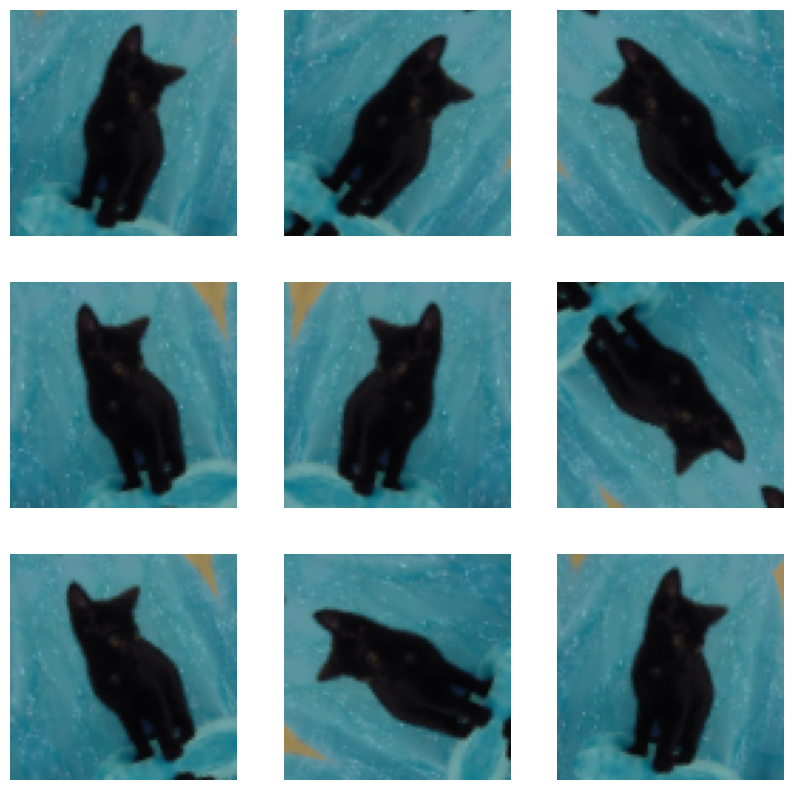

In [20]:
# https://machinelearningmastery.com/image-augmentation-with-keras-preprocessing-layers-and-tf-image/

plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

In [21]:
# add the preprocessing layers to the model

#There are two important points to be aware of in this case:

# 1. Data augmentation will run on-device, synchronously with the rest of your layers, and benefit from GPU acceleration.
# 2. When you export your model using model.save, the preprocessing layers will be saved along with the rest of your model. 
# If you later deploy this model, it will automatically standardize images (according to the configuration of your layers). 
# This can save you from the effort of having to reimplement that logic server-side.


# You will see some improvement in accuracy if you remove the RandomFlip and RandomRotation layers 
# because you make the problem easier. However, as you want the network to predict well on a wide variation 
# of image quality and properties, using augmentation can help your resulting network become more powerful.

# https://machinelearningmastery.com/image-augmentation-with-keras-preprocessing-layers-and-tf-image/

model_augmented = tf.keras.Sequential([
  # Add the preprocessing layers you created earlier.
  resize_and_rescale,
  data_augmentation,
  layers.Conv2D(
        32, (3, 3), activation="relu",
        input_shape=(150, 150, 3)
    ),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(512, activation="relu"),

    layers.Dense(1, activation="sigmoid")
])

model_augmented.compile(
    loss="binary_crossentropy",
    optimizer="rmsprop",
    metrics=["accuracy"]
)


In [22]:
train_data = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(150,150),
    batch_size=batch_size,
    color_mode="rgb"
)
#train_data = train_data.repeat(2)

validation_data = tf.keras.utils.image_dataset_from_directory(
    validation_dir,
    image_size=(150,150),
    batch_size=batch_size,
    color_mode="rgb"
)


Found 14997 files belonging to 2 classes.
Found 3706 files belonging to 2 classes.


In [23]:
type(train_data)

tensorflow.python.data.ops.prefetch_op._PrefetchDataset

In [25]:
# train_data.file_paths
train_data.class_names

['cats', 'dogs']

In [26]:
epochs = 15
history = model_augmented.fit(
    train_data,
    steps_per_epoch=len(train_data)//epochs,
    epochs=epochs,
    validation_data=validation_data
)

Epoch 1/15
31/31 [==============================] - ETA: 0s - loss: 0.7227 - accuracy: 0.5171

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


31/31 [==============================] - 7s 196ms/step - loss: 0.7227 - accuracy: 0.5171 - val_loss: 0.6926 - val_accuracy: 0.5008
Epoch 2/15
31/31 [==============================] - ETA: 0s - loss: 0.7035 - accuracy: 0.5282

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


31/31 [==============================] - 6s 189ms/step - loss: 0.7035 - accuracy: 0.5282 - val_loss: 0.6927 - val_accuracy: 0.5140
Epoch 3/15
31/31 [==============================] - ETA: 0s - loss: 0.6927 - accuracy: 0.5554

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


31/31 [==============================] - 6s 191ms/step - loss: 0.6927 - accuracy: 0.5554 - val_loss: 0.6909 - val_accuracy: 0.5227
Epoch 4/15
31/31 [==============================] - ETA: 0s - loss: 0.6874 - accuracy: 0.5585

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


31/31 [==============================] - 6s 187ms/step - loss: 0.6874 - accuracy: 0.5585 - val_loss: 0.6825 - val_accuracy: 0.5901
Epoch 5/15
31/31 [==============================] - ETA: 0s - loss: 0.6819 - accuracy: 0.5544

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


31/31 [==============================] - 6s 191ms/step - loss: 0.6819 - accuracy: 0.5544 - val_loss: 0.7014 - val_accuracy: 0.5148
Epoch 6/15
31/31 [==============================] - ETA: 0s - loss: 0.6696 - accuracy: 0.5897

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


31/31 [==============================] - 6s 187ms/step - loss: 0.6696 - accuracy: 0.5897 - val_loss: 0.7129 - val_accuracy: 0.5291
Epoch 7/15
 8/31 [======>.......................] - ETA: 2s - loss: 0.6717 - accuracy: 0.5820

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


31/31 [==============================] - ETA: 0s - loss: 0.6917 - accuracy: 0.6069

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


31/31 [==============================] - 6s 190ms/step - loss: 0.6917 - accuracy: 0.6069 - val_loss: 0.6620 - val_accuracy: 0.5912
Epoch 8/15
31/31 [==============================] - ETA: 0s - loss: 0.6567 - accuracy: 0.6220

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


31/31 [==============================] - 6s 186ms/step - loss: 0.6567 - accuracy: 0.6220 - val_loss: 0.6753 - val_accuracy: 0.5569
Epoch 9/15
31/31 [==============================] - ETA: 0s - loss: 0.6582 - accuracy: 0.6139

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


31/31 [==============================] - 6s 185ms/step - loss: 0.6582 - accuracy: 0.6139 - val_loss: 0.6670 - val_accuracy: 0.6101
Epoch 10/15
31/31 [==============================] - ETA: 0s - loss: 0.6437 - accuracy: 0.6502

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


31/31 [==============================] - 6s 185ms/step - loss: 0.6437 - accuracy: 0.6502 - val_loss: 0.6385 - val_accuracy: 0.6317
Epoch 11/15
31/31 [==============================] - ETA: 0s - loss: 0.6499 - accuracy: 0.6442

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


31/31 [==============================] - 6s 186ms/step - loss: 0.6499 - accuracy: 0.6442 - val_loss: 0.6571 - val_accuracy: 0.6044
Epoch 12/15
 4/31 [==>...........................] - ETA: 2s - loss: 0.6374 - accuracy: 0.6094

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


26/31 [========================>.....] - ETA: 0s - loss: 0.6270 - accuracy: 0.6346

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


31/31 [==============================] - ETA: 0s - loss: 0.6336 - accuracy: 0.6341

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


31/31 [==============================] - 6s 187ms/step - loss: 0.6336 - accuracy: 0.6341 - val_loss: 0.6243 - val_accuracy: 0.6562
Epoch 13/15
21/31 [===================>..........] - ETA: 0s - loss: 0.6287 - accuracy: 0.6414

27/31 [=========================>....] - ETA: 0s - loss: 0.6257 - accuracy: 0.6412

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


31/31 [==============================] - ETA: 0s - loss: 0.6293 - accuracy: 0.6371

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


31/31 [==============================] - 6s 184ms/step - loss: 0.6293 - accuracy: 0.6371 - val_loss: 0.6271 - val_accuracy: 0.6508
Epoch 14/15
31/31 [==============================] - ETA: 0s - loss: 0.6472 - accuracy: 0.6371

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


31/31 [==============================] - 6s 185ms/step - loss: 0.6472 - accuracy: 0.6371 - val_loss: 0.6368 - val_accuracy: 0.6446
Epoch 15/15
31/31 [==============================] - ETA: 0s - loss: 0.6151 - accuracy: 0.6915

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


31/31 [==============================] - 6s 188ms/step - loss: 0.6151 - accuracy: 0.6915 - val_loss: 0.6574 - val_accuracy: 0.5969


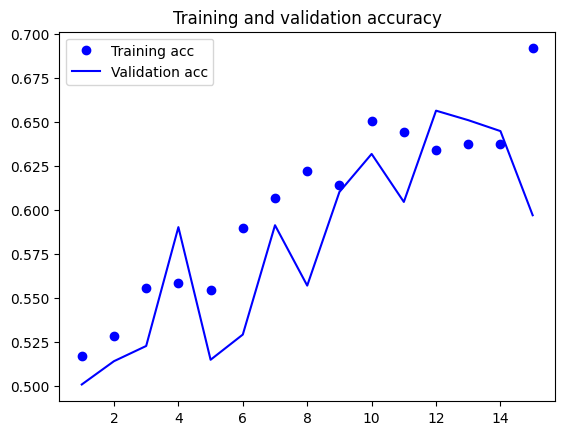

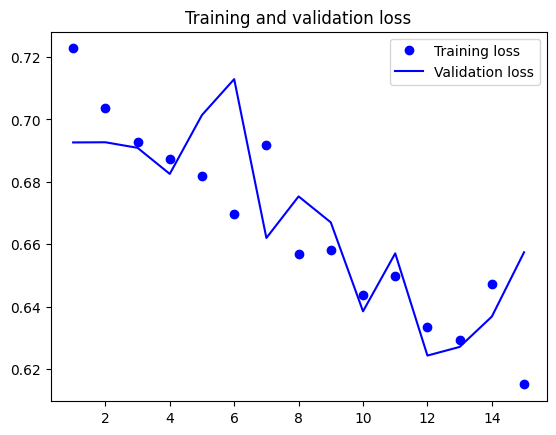

In [27]:
import matplotlib.pyplot as plt


acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")

plt.title("Training and validation accuracy")
plt.legend()

plt.figure()

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")

plt.legend()
plt.show()

In [28]:
test_dir = f"{destination}/test/"
test_data = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(150,150),
    batch_size=batch_size,
    color_mode="rgb"
)

Found 4993 files belonging to 2 classes.


In [30]:
model.evaluate(test_data)

  9/157 [>.............................] - ETA: 12s - loss: 66.4999 - accuracy: 0.6806

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 19/157 [==>...........................] - ETA: 11s - loss: 64.8693 - accuracy: 0.6842

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


 56/157 [=========>....................] - ETA: 8s - loss: 71.8648 - accuracy: 0.6574

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


116/157 [=====================>........] - ETA: 3s - loss: 71.7551 - accuracy: 0.6549

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


149/157 [===========================>..] - ETA: 0s - loss: 70.4379 - accuracy: 0.6571

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


157/157 [==============================] - 13s 81ms/step - loss: 71.6486 - accuracy: 0.6545


[71.64855194091797, 0.654516339302063]

In [29]:
model_augmented.evaluate(test_data)

 13/157 [=>............................] - ETA: 4s - loss: 0.6239 - accuracy: 0.6418

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 23/157 [===>..........................] - ETA: 4s - loss: 0.6248 - accuracy: 0.6427

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


 61/157 [==========>...................] - ETA: 2s - loss: 0.6432 - accuracy: 0.6148

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


118/157 [=====================>........] - ETA: 1s - loss: 0.6498 - accuracy: 0.6104

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


152/157 [============================>.] - ETA: 0s - loss: 0.6481 - accuracy: 0.6135

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


157/157 [==============================] - 5s 30ms/step - loss: 0.6489 - accuracy: 0.6127


[0.6488953232765198, 0.6126577258110046]

In [31]:
# data loading and preprocessing must be the same as in training!
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode="binary"
)
model.evaluate(test_generator)

Found 4993 images belonging to 2 classes.
157/157 [==============================] - 13s 84ms/step - loss: 0.5712 - accuracy: 0.7072


[0.5711705088615417, 0.7071900367736816]

1/1 [==============================] - 0s 9ms/step


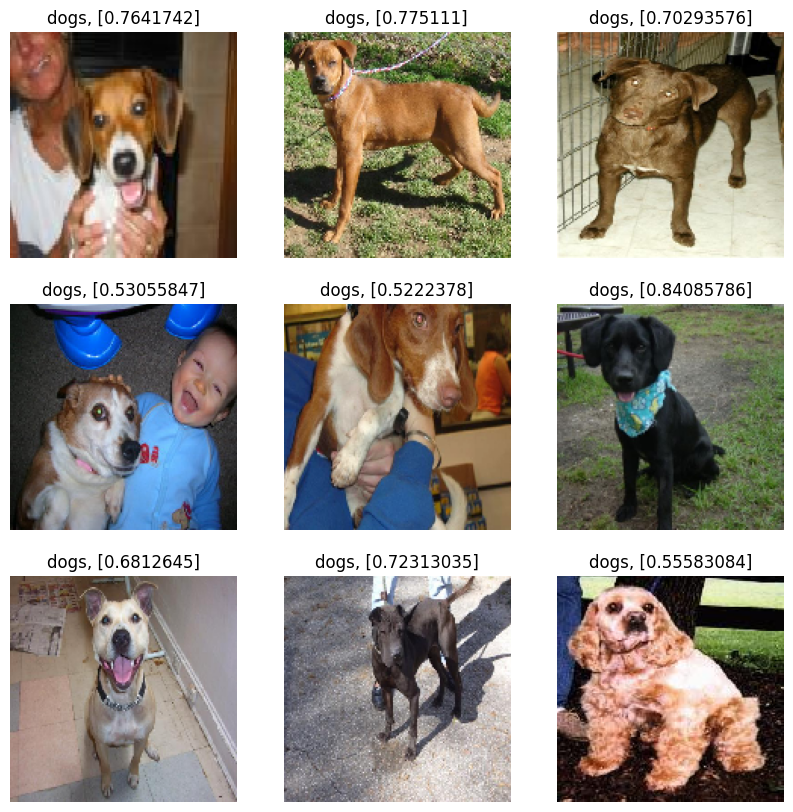

In [33]:
from keras.preprocessing import image

fnames = [
    os.path.join(test_dir + "/dogs", fname)
    for fname in os.listdir(test_dir + "/dogs")
]

plt.figure(figsize=(10, 10))
for i in range(9):
  img_path = fnames[i]
  img = image.load_img(img_path, target_size=(150, 150))

  x = image.img_to_array(img)
  x = x.reshape((1,) + x.shape)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image.array_to_img(x[0]))
  prediction = model_augmented.predict(x)[0]
  predicted_lable = test_data.class_names[1] if prediction > 0.5 else test_data.class_names[0]
  plt.title(f"{predicted_lable}, {prediction}")
  plt.axis("off")


In [34]:
# Create a confusion_matrix
import numpy as np

predictions = np.array([])
labels =  np.array([])
for x, y in test_data:
  prediction=model_augmented.predict(x) 
  classes_x=tf.constant((prediction > 0.5).astype("int32").reshape(1, -1)[0])
  predictions = np.concatenate([predictions, classes_x])
  labels = np.concatenate([labels, y])

print(len(labels))
print(len(predictions))
confusion_martix = tf.math.confusion_matrix(labels=labels, predictions=predictions).numpy()
confusion_martix

1/1 [==============================] - 0s 28ms/step


Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


1/1 [==============================] - 0s 35ms/step


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


1/1 [==============================] - 0s 35ms/step


Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


1/1 [==============================] - 0s 40ms/step


Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1/1 [==============================] - 0s 37ms/step


Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


1/1 [==============================] - 0s 9ms/step
4993
4993


array([[ 903, 1593],
       [ 341, 2156]], dtype=int32)

tf.Tensor(
[[ 903 1593]
 [ 341 2156]], shape=(2, 2), dtype=int32)


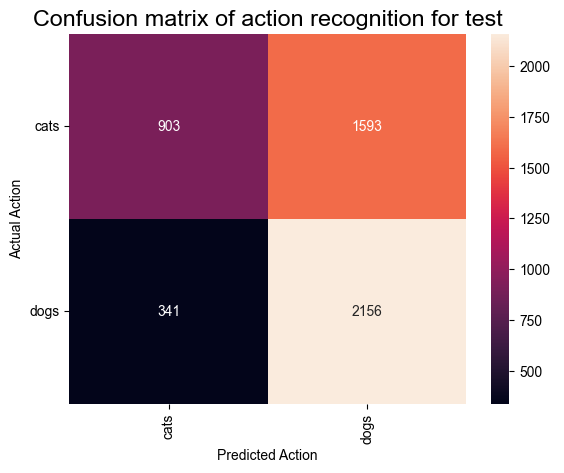

In [35]:
import seaborn as sns
def plot_confusion_matrix(actual, predicted, labels, ds_type):
  cm = tf.math.confusion_matrix(actual, predicted)
  print(cm)
  ax = sns.heatmap(cm, annot=True, fmt='g')
  sns.set(rc={'figure.figsize':(6, 6)})
  sns.set(font_scale=1.4)
  ax.set_title('Confusion matrix of action recognition for ' + ds_type)
  ax.set_xlabel('Predicted Action')
  ax.set_ylabel('Actual Action')
  plt.xticks(rotation=90)
  plt.yticks(rotation=0)
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)

plot_confusion_matrix(labels, predictions, test_data.class_names, 'test')

# ResNet (Residual Neural Network) 
Deeper networks are harder to optimize. With each extra layer that we add to a network, we add more difficulty in the process of training; it becomes harder for the optimization algorithm that we use to find the right parameters. As we add more layers, the network gets better results until at some point; then as we continue to add extra layers, the accuracy starts to drop.

https://www.neuralception.com/objectdetection-batchnorm/#residual-networks


![resnet](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*cIKFeG7ZIl9D-VnSF0KAZA.png)
https://towardsdatascience.com/building-a-resnet-in-keras-e8f1322a49ba

**How does the information flow through the skip connection?**
The skip connections, also known as shortcut connections, are active during both the forward pass and the backward pass (during backpropagation) in a ResNet architecture.

- During the forward pass:

The input data passes through the convolutional layers within a residual block.
Simultaneously, the input data also flows through the skip connection, which directly connects the input of the residual block to its output.

- During the backward pass (during backpropagation):

Gradients are computed with respect to the loss function and propagated backward through the network.
The gradients flow through both the convolutional layers and the skip connections.
The gradients that flow through the skip connections help alleviate the vanishing gradient problem by providing a direct path for gradient flow from the output to the input of the residual block.
By maintaining the skip connections throughout both the forward and backward passes, ResNet architectures enable easier optimization of deep networks and facilitate the training of very deep architectures effectively.


**Why use ResNet and not just simplify the network?**

- ResNets use skip connections to **preserve information flow** throughout the network. By directly connecting earlier layers to later layers, ResNets mitigate the risk of information loss or distortion as it passes through multiple layers. Simply removing layers doesn't address this issue.
- Removing layers without considering the network architecture can lead to degradation in performance as the depth increases. ResNets, on the other hand, **ensure that gradients can flow freely through the network**, making it easier to train deep architectures without suffering from vanishing gradients.
- The skip connections in ResNets enable feature reuse, allowing **earlier layers to directly contribute to the output of deeper layers**. This can be beneficial for tasks where certain low-level features are relevant across different parts of the network. 

Epoch 1/10
25/25 [==============================] - 1s 13ms/step - loss: 2.3118 - accuracy: 0.1088 - val_loss: 2.3116 - val_accuracy: 0.0900
Epoch 2/10
25/25 [==============================] - 0s 11ms/step - loss: 2.2974 - accuracy: 0.1138 - val_loss: 2.3242 - val_accuracy: 0.0850
Epoch 3/10
25/25 [==============================] - 0s 14ms/step - loss: 2.2875 - accuracy: 0.1125 - val_loss: 2.3060 - val_accuracy: 0.0900
Epoch 4/10
25/25 [==============================] - 0s 12ms/step - loss: 2.2150 - accuracy: 0.1412 - val_loss: 2.3358 - val_accuracy: 0.1100
Epoch 5/10
25/25 [==============================] - 0s 10ms/step - loss: 2.0318 - accuracy: 0.1863 - val_loss: 2.3721 - val_accuracy: 0.1000
Epoch 6/10
25/25 [==============================] - 0s 11ms/step - loss: 1.7959 - accuracy: 0.1950 - val_loss: 2.4831 - val_accuracy: 0.0900
Epoch 7/10
25/25 [==============================] - 0s 13ms/step - loss: 1.7553 - accuracy: 0.1963 - val_loss: 2.7407 - val_accuracy: 0.1150
Epoch 8/10
25

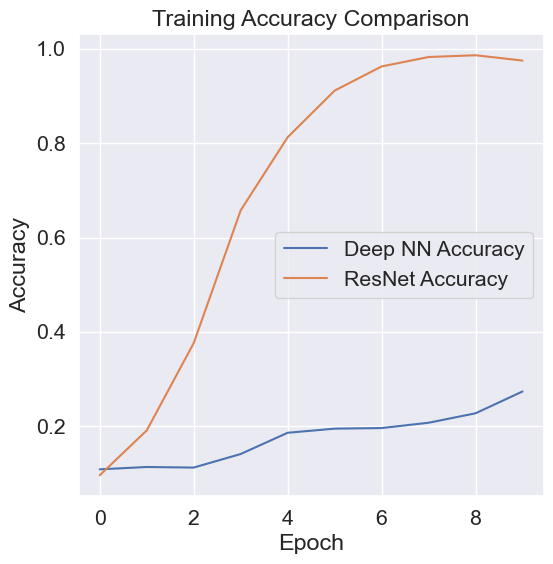

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models

# Define a simple deep neural network
# TODO: make it deeper
def build_deep_nn():
    model = models.Sequential()
    model.add(layers.Dense(512, activation='relu', input_shape=(784,)))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    return model

# Define a ResNet-like deep neural network
def build_resnet():
    input_layer = layers.Input(shape=(784,))
    x = layers.Dense(512, activation='relu')(input_layer)
    for _ in range(10):  # Adding 10 residual blocks
        residual = x  # residual = F(x) - x  # різниця
        # two stacked blocks
        x = layers.Dense(512, activation='relu')(x)
        x = layers.Dense(512, activation=None)(x)  # No activation after the second layer, https://stats.stackexchange.com/questions/623551/no-activation-function-between-two-convolutional-layers-in-munit
        x = layers.Add()([x, residual])  # Adding the shortcut connection
        x = layers.Activation('relu')(x)
    output_layer = layers.Dense(10, activation='softmax')(x)
    model = models.Model(inputs=input_layer, outputs=output_layer)
    return model

# Generate synthetic data
num_samples = 1000
input_data = np.random.randn(num_samples, 784)
labels = np.random.randint(0, 10, size=(num_samples,))

# Build and compile the deep neural network
deep_nn = build_deep_nn()
deep_nn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the deep neural network
deep_nn_history = deep_nn.fit(input_data, labels, epochs=10, batch_size=32, validation_split=0.2)

# Build and compile the ResNet-like neural network
resnet = build_resnet()
resnet.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the ResNet-like neural network
resnet_history = resnet.fit(input_data, labels, epochs=10, batch_size=32, validation_split=0.2)

# Plot the training history
plt.plot(deep_nn_history.history['accuracy'], label='Deep NN Accuracy')
plt.plot(resnet_history.history['accuracy'], label='ResNet Accuracy')
plt.title('Training Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [37]:
from tensorflow.keras import layers, models

# Define the residual block
def residual_block(x, filters, kernel_size):
    shortcut = x
    
    # First convolutional layer
    x = layers.Conv2D(filters, kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)  # https://www.neuralception.com/objectdetection-batchnorm/#:~:text=In%20summary%2C%20batch%20normalization%20is,normalization%20offers%20some%20regularization%20effect.
    x = layers.Activation('relu')(x)
    
    # Second convolutional layer
    x = layers.Conv2D(filters, kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)
    
    # Add the shortcut connection
    if shortcut.shape[-1] != filters:  # If number of channels is not equal, apply 1x1 convolution to match dimensions
        shortcut = layers.Conv2D(filters, (1, 1), padding='same')(shortcut)
    x = layers.add([shortcut, x])
    x = layers.Activation('relu')(x)
    return x

# Build the model using residual layers
input_layer = layers.Input(shape=(150, 150, 3))
x = layers.Conv2D(32, (3, 3), activation="relu")(input_layer)
x = layers.MaxPooling2D((2, 2))(x)

# Add residual blocks
x = residual_block(x, filters=64, kernel_size=(3, 3))
x = layers.MaxPooling2D((2, 2))(x)

x = residual_block(x, filters=128, kernel_size=(3, 3))
x = layers.MaxPooling2D((2, 2))(x)

x = residual_block(x, filters=128, kernel_size=(3, 3))
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Flatten()(x)
x = layers.Dense(512, activation="relu")(x)
output_layer = layers.Dense(1, activation="sigmoid")(x)

# Create model
model_res_net = models.Model(inputs=input_layer, outputs=output_layer)


In [38]:
model_res_net.compile(
    loss="binary_crossentropy",
    optimizer="rmsprop",
    metrics=["accuracy"]
)

In [39]:
from tensorflow.keras.callbacks import ModelCheckpoint
# No checkpoints used here because they would result from training on part of the data

epochs = 15

history = model_res_net.fit(
    train_data,
    steps_per_epoch=len(train_data)//epochs,
    epochs=epochs,
    validation_data=validation_data,
)

Epoch 1/15
31/31 [==============================] - ETA: 0s - loss: 81.7761 - accuracy: 0.5171

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


31/31 [==============================] - 50s 2s/step - loss: 81.7761 - accuracy: 0.5171 - val_loss: 16.7694 - val_accuracy: 0.5030
Epoch 2/15
 1/31 [..............................] - ETA: 22s - loss: 2.1323 - accuracy: 0.7188

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt


acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")

plt.title("Training and validation accuracy")
plt.legend()

plt.figure()

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")

plt.legend()
plt.show()

In [ ]:
model_res_net.save("res_net.keras")

In [ ]:
model_res_net.evaluate(test_data)

ResNet Versions:
https://medium.com/mlearning-ai/a-quick-overview-of-resnet-models-f8ed277ae81e

# Pretrained models

In [42]:
from tensorflow.keras.models import load_model
model_res_net = load_model("res_net.keras")
model_res_net.layers

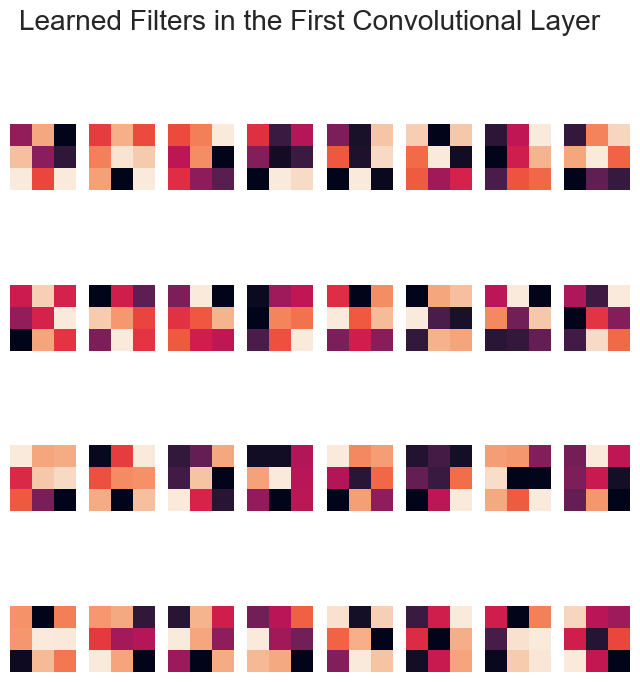

In [43]:
# Extract the filters from the first convolutional layer - feature extraction!
filters = model_res_net.layers[1].get_weights()[0]

# Visualize the learned filters
# Learned Filters:
# The first part of the code visualizes the learned filters from the first convolutional layer. Each filter is a small matrix 
# of weights that slides over the input image, capturing different features.

plt.figure(figsize=(8, 8))
for i in range(32):
    plt.subplot(4, 8, i + 1)
    plt.imshow(filters[:, :, 0, i])
    plt.axis('off')
plt.suptitle('Learned Filters in the First Convolutional Layer')
plt.show()


In [44]:
from tensorflow.keras.applications import ResNet50
ResNet_50 = ResNet50(weights=None)
# parameter number: 
ResNet_50.count_params()

25636712

In [45]:
ResNet_50.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_3[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

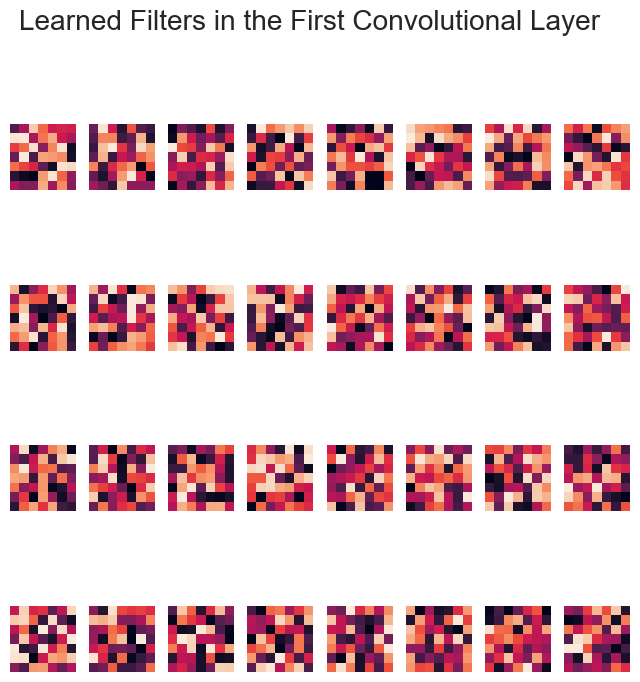

In [46]:
# Extract the filters from the first convolutional layer
filters = ResNet_50.layers[2].get_weights()[0]

# Visualize the learned filters
# Learned Filters:
# The first part of the code visualizes the learned filters from the first convolutional layer. Each filter is a small matrix 
# of weights that slides over the input image, capturing different features.

plt.figure(figsize=(8, 8))
for i in range(32):
    plt.subplot(4, 8, i + 1)
    plt.imshow(filters[:, :, 0, i])
    plt.axis('off')
plt.suptitle('Learned Filters in the First Convolutional Layer')
plt.show()

In [47]:
# Pretrained model on ImageNet https://www.image-net.org
# https://paperswithcode.com/dataset/imagenet
# based on https://wordnet.princeton.edu
# The most highly-used subset of ImageNet is the ImageNet Large Scale Visual Recognition Challenge (ILSVRC) 2012-2017 image classification and localization dataset. 
# This dataset spans 1000 object classes and contains 1,281,167 training images, 50,000 validation images and 100,000 test images.

from tensorflow import keras
pretrained_resnet50 = keras.applications.ResNet50(
    weights="imagenet",
    classes=1000,
    classifier_activation="softmax",
)

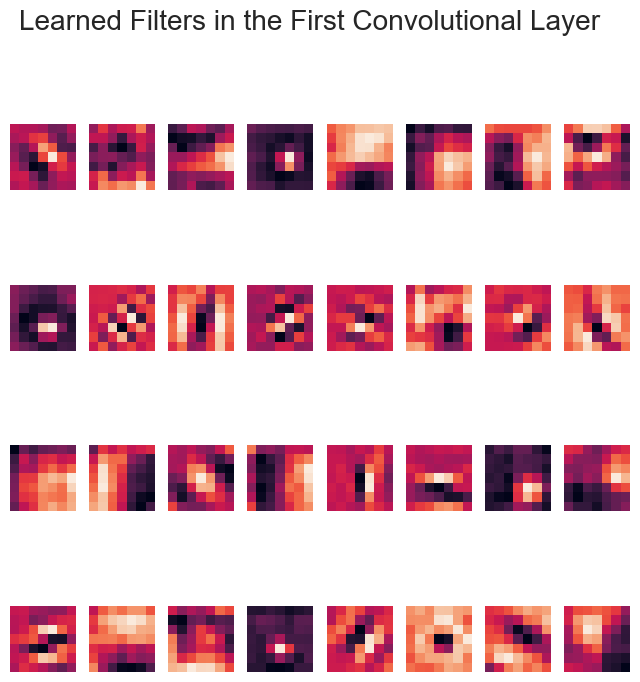

In [49]:
# Extract the filters from the first convolutional layer
filters = pretrained_resnet50.layers[2].get_weights()[0]

# Visualize the learned filters
# Learned Filters:
# The first part of the code visualizes the learned filters from the first convolutional layer. Each filter is a small matrix 
# of weights that slides over the input image, capturing different features.

plt.figure(figsize=(8, 8))
for i in range(32):
    plt.subplot(4, 8, i + 1)
    plt.imshow(filters[:, :, 0, i])
    plt.axis('off')
plt.suptitle('Learned Filters in the First Convolutional Layer')
plt.show()

https://en.wikipedia.org/wiki/Zero-shot_learning

In [50]:
import json
from urllib import request

# Download the label mapping file
url = "https://raw.githubusercontent.com/raghakot/keras-vis/master/resources/imagenet_class_index.json"
response = request.urlopen(url)
data = json.loads(response.read())

# Create a dictionary to map class indices to labels
label_mapping = {int(idx): label for idx, (_, label) in data.items()}

# Print the label mapping
print(label_mapping)


{0: 'tench', 1: 'goldfish', 2: 'great_white_shark', 3: 'tiger_shark', 4: 'hammerhead', 5: 'electric_ray', 6: 'stingray', 7: 'cock', 8: 'hen', 9: 'ostrich', 10: 'brambling', 11: 'goldfinch', 12: 'house_finch', 13: 'junco', 14: 'indigo_bunting', 15: 'robin', 16: 'bulbul', 17: 'jay', 18: 'magpie', 19: 'chickadee', 20: 'water_ouzel', 21: 'kite', 22: 'bald_eagle', 23: 'vulture', 24: 'great_grey_owl', 25: 'European_fire_salamander', 26: 'common_newt', 27: 'eft', 28: 'spotted_salamander', 29: 'axolotl', 30: 'bullfrog', 31: 'tree_frog', 32: 'tailed_frog', 33: 'loggerhead', 34: 'leatherback_turtle', 35: 'mud_turtle', 36: 'terrapin', 37: 'box_turtle', 38: 'banded_gecko', 39: 'common_iguana', 40: 'American_chameleon', 41: 'whiptail', 42: 'agama', 43: 'frilled_lizard', 44: 'alligator_lizard', 45: 'Gila_monster', 46: 'green_lizard', 47: 'African_chameleon', 48: 'Komodo_dragon', 49: 'African_crocodile', 50: 'American_alligator', 51: 'triceratops', 52: 'thunder_snake', 53: 'ringneck_snake', 54: 'hogn

1/1 [==============================] - 0s 56ms/step


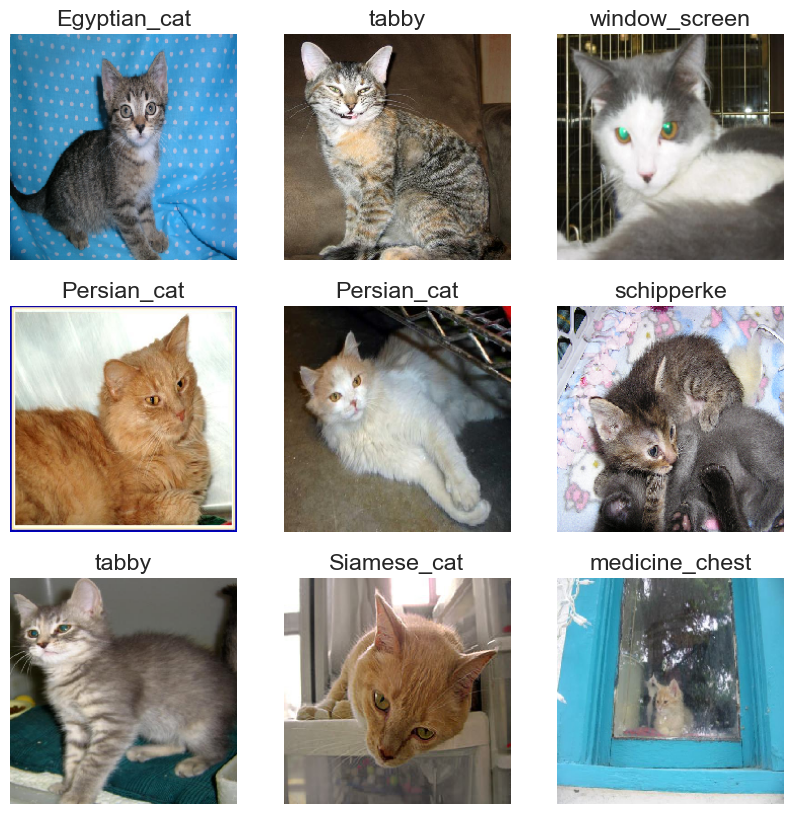

In [52]:
from keras.preprocessing import image

fnames = [
    os.path.join(test_dir + "/cats", fname)
    for fname in os.listdir(test_dir + "/cats")
]

plt.figure(figsize=(10, 10))
for i in range(9):
  img_path = fnames[i]
  img = image.load_img(img_path, target_size=(224, 224))

  x = image.img_to_array(img)
  x = x.reshape((1,) + x.shape)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image.array_to_img(x[0]))
  prediction = pretrained_resnet50.predict(x)[0]
  predicted_class = np.argmax(prediction, axis=0)
  predicted_label = label_mapping[predicted_class]

  plt.title(f"{predicted_label}")
  # plt.title(f"{predicted_lable}, {prediction}")
  plt.axis("off")

https://keras.io/api/applications/resnet/

https://www.analyticsvidhya.com/blog/2021/03/introduction-to-the-architecture-of-alexnet/

https://medium.com/@kyan7472/these-are-the-5-best-pre-trained-neural-networks-23798e61a043


In [56]:
# finetune the ResNet
from keras.applications import ResNet50
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Dense
#from keras.optimizers import Adam
from keras.optimizers.legacy import Adam

num_classes = 1

# Load pretrained ResNet50 model without top layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add your classifier
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)  # num_classes is the number of classes in your dataset

model_finetuned = Model(inputs=base_model.input, outputs=predictions)

# Freeze some layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model_finetuned.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

epochs = 5
# Train the model
model_finetuned.fit(
    train_data_224,
    epochs=epochs,
    validation_data=validation_data_224
)

Epoch 1/5


Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


 51/469 [==>...........................] - ETA: 7:06 - loss: 0.2597 - accuracy: 0.5104

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


 71/469 [===>..........................] - ETA: 6:45 - loss: 0.1999 - accuracy: 0.5084

KeyboardInterrupt: 

In [55]:
train_data_224 = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(224,224),
    batch_size=batch_size,
    color_mode="rgb"
)

validation_data_224 = tf.keras.utils.image_dataset_from_directory(
    validation_dir,
    image_size=(224,224),
    batch_size=batch_size,
    color_mode="rgb"
)

Found 14997 files belonging to 2 classes.
Found 3706 files belonging to 2 classes.


In [ ]:
# Optionally, fine-tuning by unfreezing some layers

"""
for layer in model.layers[:100]:
    layer.trainable = False
for layer in model.layers[100:]:
    layer.trainable = True

# Continue training
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(
    train_data,
    epochs=1,
    batch_size=32,
    validation_data=validation_data
)
"""

https://keras.io/examples/vision/yolov8/

https://github.com/onnx/models